In [1]:
import os
import sys
sys.path.append('/global/homes/q/qmxp55/DESI/omarlibs')
import raichoorlib
import numpy as np
np.seterr(divide='ignore') # ignode divide by zero warnings
import astropy.io.fits as fits
import fitsio
import glob
import healpy as hp
from astropy.coordinates import SkyCoord
import astropy.units as units
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle


## Input files

In [2]:
#input files

inptfiles = {}

inptfiles['dr8randroot']= '/project/projectdirs/desi/target/catalogs/dr8/0.31.0/randoms/randoms-inside-dr8-0.31.0-'
inptfiles['dr8pix']     = '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/pixweight/pixweight-dr8-0.31.1.fits'
inptfiles['desitile']   = '/global/cscratch1/sd/raichoor/desi-tiles-viewer.fits' # from Eddie, see [desi-survey 647]
inptfiles['bgssvdr8']   = '/global/cscratch1/sd/qmxp55/bgs_sv_dr8_0.31.1.npy'

for file in inptfiles.keys():
    print(file, '\t=', inptfiles[file])


dr8randroot 	= /project/projectdirs/desi/target/catalogs/dr8/0.31.0/randoms/randoms-inside-dr8-0.31.0-
dr8pix 	= /project/projectdirs/desi/target/catalogs/dr8/0.31.1/pixweight/pixweight-dr8-0.31.1.fits
desitile 	= /global/cscratch1/sd/raichoor/desi-tiles-viewer.fits
bgssvdr8 	= /global/cscratch1/sd/qmxp55/bgs_sv_dr8_0.31.1.npy


The input files needed for this notebook are:

* dr8randroot: the randoms of LS DR8 created by DESITARGET. These are divided into 10 fits files each one with a target density of 5000. For more info go to: http://legacysurvey.org/dr8/files/#random-catalogs
* dr8pix: the healpix pixel weights map. Includes information such as the stellar density from GAIA DR2, the extinction, the psfsizes and galdepths for the three bands.
* desitile: the tiles pattern for the DESI footprint (~14000 deg^2). Includes tiles centers.
* bgssvdr8: the BGS SV catalogue. Include the DESITARGET columns to select the supersets and magnitudes in the three bands plus the fiber magnitude in the r-band.

## Settings and functions

In [3]:
#settings
org          = 120  # centre ra for mollweide plots
Nranfiles = 2
veto_maskbits= [1] #BGS only applies the BS masking
dec_resol_ns = 32.375 # ADM dec to split north/south
projection   = 'mollweide'
# for healpy
hdr          = fits.getheader(inptfiles['dr8pix'],1)
nside,nest   = hdr['hpxnside'],hdr['hpxnest']
npix         = hp.nside2npix(nside)
pixarea      = hp.nside2pixarea(nside,degrees=True)

In [4]:
# is in desi nominal footprint? (using tile radius of 1.6 degree)
# small test shows that it broadly works to cut on desi footprint 
def get_isdesi(ra,dec):
    radius   = 1.6 # degree
    tmpnside = 16
    tmpnpix  = hp.nside2npix(tmpnside)
    # first reading desi tiles, inside desi footprint (~14k deg2)
    hdu  = fits.open(inptfiles['desitile'])
    data = hdu[1].data
    keep = (data['in_desi']==1)
    data = data[keep]
    tra,tdec = data['ra'],data['dec']
    # get hppix inside desi tiles
    theta,phi  = hp.pix2ang(tmpnside,np.arange(tmpnpix),nest=nest)
    hpra,hpdec = 180./np.pi*phi,90.-180./np.pi*theta
    hpindesi   = np.zeros(tmpnpix,dtype=bool)
    _,ind,_,_,_= raichoorlib.search_around(tra,tdec,hpra,hpdec,search_radius=1.6*3600)
    hpindesi[np.unique(ind)] = True
    ## small hack to recover few rejected pixels inside desi. Avoid holes if any
    tmp  = np.array([i for i in range(tmpnpix) 
                     if hpindesi[hp.get_all_neighbours(tmpnside,i,nest=nest)].sum()==8])
    hpindesi[tmp] = True
    ##
    pixkeep    = np.where(hpindesi)[0]
    # now compute the hppix for the tested positions
    pix  = hp.ang2pix(tmpnside,(90.-dec)*np.pi/180.,ra*np.pi/180.,nest=nest)
    keep = np.in1d(pix,pixkeep)
    return keep

# my colormaps
cm = raichoorlib.mycmap(matplotlib.cm.jet, 10,0,1)
cmr= raichoorlib.mycmap(matplotlib.cm.jet_r,10,0,1)


# mollweide plot setting
# http://balbuceosastropy.blogspot.com/2013/09/the-mollweide-projection.html
def set_mwd(ax,org=0):
    # org is the origin of the plot, 0 or a multiple of 30 degrees in [0,360).
    tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    tick_labels = np.remainder(tick_labels+360+org,360)
    ax.set_xticklabels(tick_labels)     # we add the scale on the x axis
    ax.set_xlabel('R.A [deg]')
    ax.xaxis.label.set_fontsize(12)
    ax.set_ylabel('Dec. [deg]')
    ax.yaxis.label.set_fontsize(12)
    ax.grid(True)
    return True


# convert radec for mollwide
def get_radec_mw(ra,dec,org):
    ra          = np.remainder(ra+360-org,360) # shift ra values
    ra[ra>180] -= 360    # scale conversion to [-180, 180]
    ra          =- ra    # reverse the scale: East to the left
    return np.radians(ra),np.radians(dec)

# plot/xlim settings
def get_systplot(systquant):
    tmparray = np.array([
        'stardens',      [2.2,3.6],  r'log10(Stellar density from Gaia/dr2 [deg$^{-2}$])',
        'ebv',           [0.001,0.2],'Galactic extinction ebv [mag]',
        'psfsize_g',     [1.0,2.5],  'g-band psfsize [arcsec]',
        'psfsize_r',     [0.9,2.5],  'r-band psfsize [arcsec]',
        'psfsize_z',     [0.8,2.0],  'z-band psfsize [arcsec]',
        'galdepth_g',    [23.0,25.5],'g-band 5sig. galdepth [mag]',
        'galdepth_r',    [22.5,25.0],'r-band 5sig. galdepth [mag]',
        'galdepth_z',    [21.5,24.0],'z-band 5sig. galdepth [mag]'],
        dtype='object')
    tmparray = tmparray.reshape(int(tmparray.shape[0]/3),3)
    tmpind   = np.where(tmparray[:,0]==systquant.lower())[0][0]
    return tmparray[tmpind,1], tmparray[tmpind,2]

## Creating a dictionary with healpix information from the randoms and pixweights catalogues

In the code below we create a new dictionary called `hpdict` and we fill this with information of the randosm and pixweights such as the systematics in healpix format. The healpix format use the same `nside` and `npix` of the `dr8pix` healpix file.

The information we stored in `hpdict` includes:

* positions of the healpix pixels in RA and DEC form.
* positions of the healpix pixels in galactic coordinates (l,b). This will be useful to define the survey nort/south boundaries.
* if a pixel lies within the DESI footprint using the `get_isdesi` function.
* systematics propagated from `dr8pix` pixweight catalogue.
* bgs sv fractional area. This come from the randoms only where in BGS SV we only apply the geometrical cuts `NOBS_[G,R,Z] > 0` and `Bright Star Masking`. The fractional area is defined as: $f_{A} = N_{pix}/\eta \cdot A_{pix}^{-1}$ where $N_{pix}$ is the number of objects within the pixel after applying the masks, $\eta$ is the density of the randoms without any mask ($5000$ deg$^{-2}$ per file) and $A_{pix}^{-1}$ is the area of the pixel $0.052$ deg$^2$ in this case.
* if a pixel lies within the north/south/des/decals regions.
* the total area in north/south/des/decals/all regions defined by $A_{i} = \sum f_{A}(i) \cdot A_{pix}$

With this information we are going to plot the sky distributions of the different surveys footprint, the fractional area ($f_{A}$), the stellar density and extinction.

In [5]:
# creating dictionary
hpdict     = {}
theta,phi  = hp.pix2ang(nside,np.arange(npix),nest=nest)
hpdict['ra'],hpdict['dec'] = 180./np.pi*phi,90.-180./np.pi*theta
c          = SkyCoord(hpdict['ra']*units.degree,hpdict['dec']*units.degree, frame='icrs')
hpdict['gall'],hpdict['galb'] = c.galactic.l.value,c.galactic.b.value

# is in desi tile?
hpdict['isdesi'] = get_isdesi(hpdict['ra'],hpdict['dec'])

# propagating some keys from ADM pixweight
hdu        = fits.open(inptfiles['dr8pix'])
data       = hdu[1].data
for key in ['HPXPIXEL', 'FRACAREA', 
            'STARDENS', 'EBV', 
            'PSFDEPTH_G', 'PSFDEPTH_R', 'PSFDEPTH_Z',
            'GALDEPTH_G', 'GALDEPTH_R', 'GALDEPTH_Z',
            'PSFDEPTH_W1', 'PSFDEPTH_W2',
            'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z']:
    if (key=='STARDENS'):
        hpdict[key.lower()] = np.log10(data[key])
    elif (key[:8]=='GALDEPTH'):
        hpdict[key.lower()] = 22.5-2.5*np.log10(5./np.sqrt(data[key]))
    else:
        hpdict[key.lower()] = data[key]
        

# reading randoms to get bgs fraction area
# (using all rand files to minimize poisson noise in the area estimation)
# (however using only 1 rand file should also provide reasonable results; and be x10 faster)
fns  = glob.glob(inptfiles['dr8randroot']+'*.fits')
fns = fns[0:Nranfiles]
## initialising
randdens,ra,dec = 0,[],[]
## looping on rand files
for fn in fns:
    print(fn.split('/')[-1])
    hdu  = fits.open(fn)
    data = hdu[1].data
    ## cutting on desi footprint
    data = data[get_isdesi(data['ra'],data['dec'])]
    norig = len(data)
    ## cut on g+r+z
    keep = (data['nobs_g']>0) & (data['nobs_r']>0) & (data['nobs_z']>0)
    print('keeping ', len(data[keep]), '/', norig, 'after cutting on g+r+z')
    ## cut on maskbits
    for bit in veto_maskbits:
        keep &= ((data['maskbits'] & 2**bit)==0)
    print('keeping ', len(data[keep]), '/', norig, 'after cutting on g+r+z and maskbits')
    data = data[keep]
    ## updating
    randdens += float(hdu[1].header['density'])
    ra       += data['ra'].tolist()
    dec      += data['dec'].tolist()
print('randdens = ', randdens, ' ; len(ra) = ', len(ra))

# computing areas
hppix           = hp.ang2pix(nside,(90.-np.array(dec))*np.pi/180.,np.array(ra)*np.pi/180.,nest=nest)
ind,c           = np.unique(hppix,return_counts=True)
hpdict['bgsfracarea']      = np.zeros(npix)
hpdict['bgsfracarea'][ind] = c / randdens / pixarea

# north/south/des/decals
hpdict['issouth'] = np.zeros(npix,dtype=bool)
tmp               = (hpdict['bgsfracarea']>0) & ((hpdict['galb']<0) | ((hpdict['galb']>0) & (hpdict['dec']<dec_resol_ns)))
hpdict['issouth'][tmp] = True
hpdict['isnorth'] = np.zeros(npix,dtype=bool)
tmp               = (hpdict['bgsfracarea']>0) & (hpdict['dec']>dec_resol_ns) & (hpdict['galb']>0)
hpdict['isnorth'][tmp] = True
hpdict['isdes']   = raichoorlib.get_isdes(hpdict['ra'],hpdict['dec'])
hpdict['isdecals']= (hpdict['issouth']) & (~hpdict['isdes'])

# areas
hpdict['area_all']   = hpdict['bgsfracarea'].sum() * pixarea
for reg in ['south','decals','des','north']:
    hpdict['bgsarea_'+reg]   = hpdict['bgsfracarea'][hpdict['is'+reg]].sum() * pixarea 

1207 nearby objects


/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in sqrt


randoms-inside-dr8-0.31.0-8.fits
1207 nearby objects
keeping  70965835 / 71326592 after cutting on g+r+z
keeping  69066565 / 71326592 after cutting on g+r+z and maskbits
randoms-inside-dr8-0.31.0-10.fits
1207 nearby objects
keeping  70964193 / 71325476 after cutting on g+r+z
keeping  69064468 / 71325476 after cutting on g+r+z and maskbits
randdens =  10000.0  ; len(ra) =  138131033


2019-10-15 18:29:47 start
areas for for hp pix inside desi footprint:
dr8  = 13813 deg2
south = 9409 deg2
decals = 8321 deg2
des = 1088 deg2
north = 4404 deg2


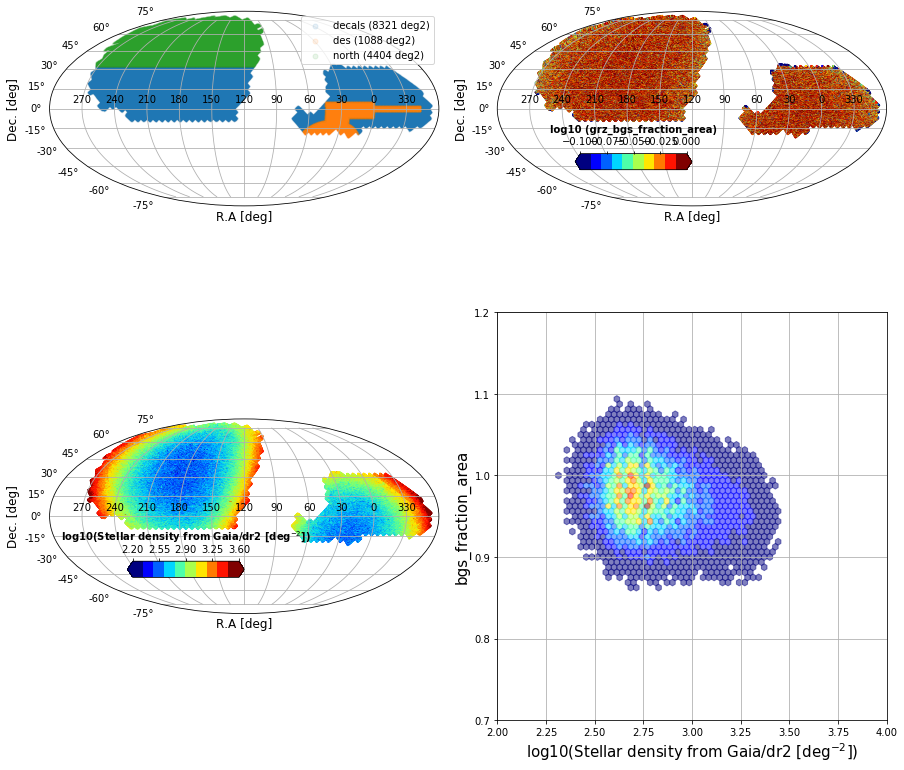

2019-10-15 18:30:04 end


In [6]:
# hp quantities diagnosis
print(raichoorlib.get_date(), 'start')

# areas
print('areas for for hp pix inside desi footprint:')
print('==============')
hpdict['area_all']   = hpdict['bgsfracarea'].sum() * pixarea
print('dr8  = '+'%.0f'%hpdict['area_all']+' deg2')
for reg in ['south','decals','des','north']:
    print(reg+' = '+'%.0f'%hpdict['bgsarea_'+reg]+' deg2')
print('==============')

fig    = plt.figure(figsize=(15,15))
gs     = gridspec.GridSpec(2,2,wspace=0.15,hspace=0)

## plotting subregions
ax     = plt.subplot(gs[0],projection=projection)
_      = set_mwd(ax,org=org)
ramw,decmw = get_radec_mw(hpdict['ra'],hpdict['dec'],org)
for reg in ['decals','des','north']:
    tmp    = (hpdict['bgsfracarea']>0) & (hpdict['is'+reg])
    SC = ax.scatter(ramw[tmp],decmw[tmp],s=1,alpha=0.1,
                    label=reg+' ('+'%.0f'%hpdict['bgsarea_'+reg]+' deg2)')
ax.legend(markerscale=5)

# plotting bgsfracarea
cmin,cmax  = -0.1,0
cbarticks  = np.linspace(cmin,cmax,5)
cbar_ylab  = ['%.2f' % x for x in cbarticks]
ax     = plt.subplot(gs[1],projection=projection)
_      = set_mwd(ax,org=org)
ramw,decmw = get_radec_mw(hpdict['ra'],hpdict['dec'],org)
tmp        = (hpdict['bgsfracarea']>0)
SC         = ax.scatter(ramw[tmp],decmw[tmp],s=1,
    c=np.log10(hpdict['bgsfracarea'][tmp]),
    cmap=cm,vmin=cmin,vmax=cmax,rasterized=True)
# https://stackoverflow.com/questions/41428442/horizontal-colorbar-over-2-of-3-subplots
p    = ax.get_position().get_points().flatten()
cax  = fig.add_axes([p[0]+0.2*(p[2]-p[0]),p[1]+0.35*(p[3]-p[1]),0.3*(p[2]-p[0]),0.015])
cbar = plt.colorbar(SC, cax=cax, orientation='horizontal', ticklocation='top', extend='both', ticks=cbarticks)
cbar.set_label('log10 (grz_bgs_fraction_area)',fontweight='bold')
cbar.ax.set_yticklabels(cbar_ylab)

# plotting stellar density
cmin,cmax  = 2.2, 3.6
cbarticks  = np.linspace(cmin,cmax,5)
cbar_ylab  = ['%.2f' % x for x in cbarticks]
ax     = plt.subplot(gs[2],projection=projection)
_      = set_mwd(ax,org=org)
ramw,decmw = get_radec_mw(hpdict['ra'],hpdict['dec'],org)
tmp        = (hpdict['bgsfracarea']>0)
SC         = ax.scatter(ramw[tmp],decmw[tmp],s=1,
    c=hpdict['stardens'][tmp],
    cmap=cm,vmin=cmin,vmax=cmax,rasterized=True)
p    = ax.get_position().get_points().flatten()
cax  = fig.add_axes([p[0]+0.2*(p[2]-p[0]),p[1]+0.35*(p[3]-p[1]),0.3*(p[2]-p[0]),0.015])
cbar = plt.colorbar(SC, cax=cax, orientation='horizontal', ticklocation='top', extend='both', ticks=cbarticks)
cbar.set_label(r'log10(Stellar density from Gaia/dr2 [deg$^{-2}$])',fontweight='bold')
cbar.ax.set_yticklabels(cbar_ylab)

# bgsfracarea / fracarea = f(stardens)
tmp    = (hpdict['bgsfracarea']>0)
ax     = plt.subplot(gs[3])
xlim,xlab = (2,4),r'log10(Stellar density from Gaia/dr2 [deg$^{-2}$])'
ylim,ylab = (0.7,1.2),'bgs_fraction_area'
HB = ax.hexbin(hpdict['stardens'][tmp],hpdict['bgsfracarea'][tmp],C=None,
        gridsize=70,extent=(xlim[0],xlim[1],ylim[0],ylim[1]),cmap=cm,mincnt=50,
        alpha=0.5)
ax.set_xlabel(xlab,fontsize=15)
ax.set_ylabel(ylab,fontsize=15)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.grid(True)

plt.show()
plt.close()

print(raichoorlib.get_date(), 'end')

## Load BGS SV data and get target densities + sanity check

Now we move to our target catalogue `bgssvdr8` and compute the number of targets in the healpix pixels for each of the SV supersets (bright/faint/faint_ext/fibmag/lowq) and for the nort/south regions. The target density is defined as $\eta_{pix}^{bgs}(bit) = N_{pix}^{bgs}(bit)/(A_{pix} \cdot f_{A})$. Finally we get the mean density ($\bar{\eta}_{pix}^{bgs}(bit)$) and add this to the `hpdict`.

To select the sv bits we use the `SV1_BGS_TARGET` information from DESITARGET. The bits and bitvalues key is below:

    name	       bitnums	bitvals
    BGS_FAINT	    0	        1
    BGS_BRIGHT	   1	        2
    BGS_FAINT_EXT    2	        4
    BGS_LOWQ	     3	        8
    BGS_FIBMAG	   4	       16
    
To make sure we haven't mess things around, we run a sanity check with a random subsample of $1$%. We make colour plots of $g-r$, $r-z$ and scatter plots of $rmag$ vs $rfibmag$ plus their distributions for all the SV bits and for each of the nort/south regions.

2019-10-15 18:57:59 start
1207 nearby objects
computing for  north / any
computing for  north / bright
computing for  north / faint
computing for  north / faint_ext
computing for  north / fibmag
computing for  north / lowq
plotting for  north / any
plotting for  north / bright
plotting for  north / faint
plotting for  north / faint_ext
plotting for  north / fibmag
plotting for  north / lowq


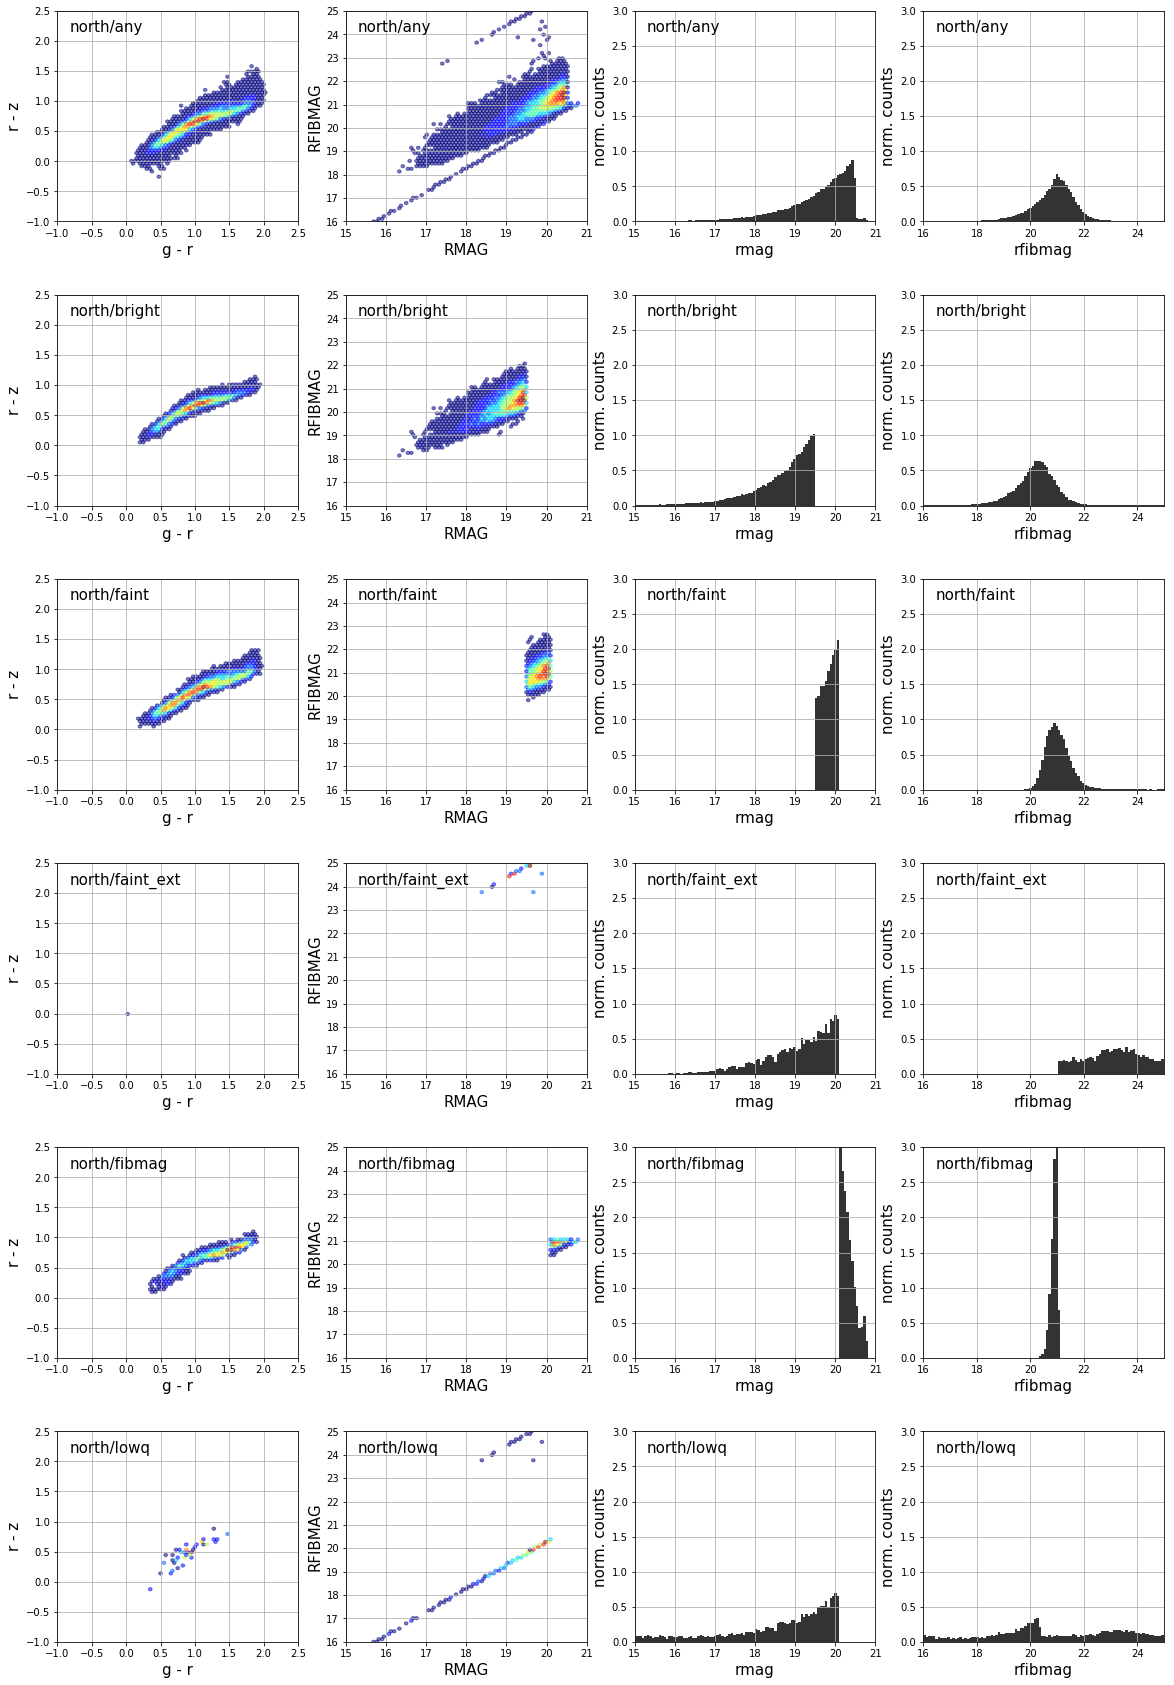

1207 nearby objects
computing for  south / any
computing for  south / bright
computing for  south / faint
computing for  south / faint_ext
computing for  south / fibmag
computing for  south / lowq
plotting for  south / any
plotting for  south / bright
plotting for  south / faint
plotting for  south / faint_ext
plotting for  south / fibmag
plotting for  south / lowq


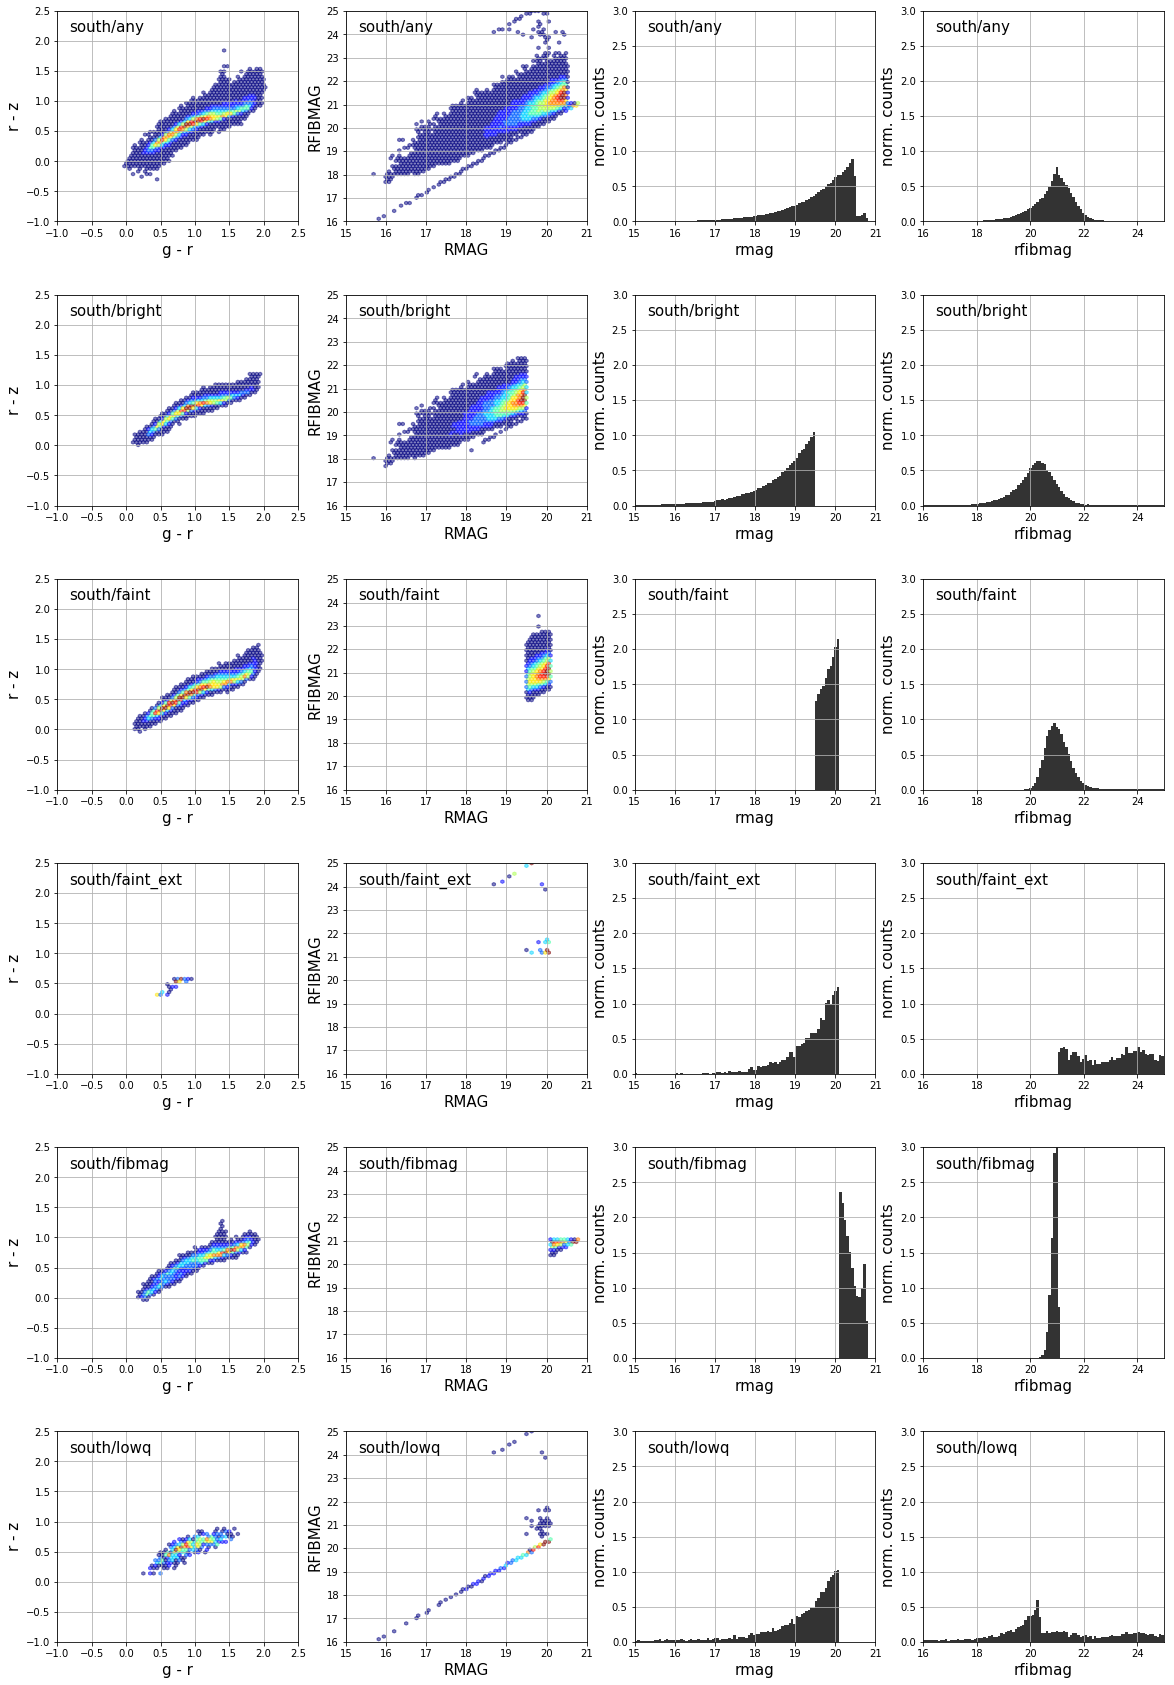

any
meandens_any_all = 2547 /deg2
meandens_any_des = 2469 /deg2
meandens_any_decals = 2546 /deg2
meandens_any_north = 2566 /deg2
bright
meandens_bright_all = 845 /deg2
meandens_bright_des = 855 /deg2
meandens_bright_decals = 852 /deg2
meandens_bright_north = 830 /deg2
faint
meandens_faint_all = 736 /deg2
meandens_faint_des = 738 /deg2
meandens_faint_decals = 738 /deg2
meandens_faint_north = 733 /deg2
faint_ext
meandens_faint_ext_all = 624 /deg2
meandens_faint_ext_des = 622 /deg2
meandens_faint_ext_decals = 622 /deg2
meandens_faint_ext_north = 629 /deg2
fibmag
meandens_fibmag_all = 215 /deg2
meandens_fibmag_des = 207 /deg2
meandens_fibmag_decals = 236 /deg2
meandens_fibmag_north = 179 /deg2
lowq
meandens_lowq_all = 125 /deg2
meandens_lowq_des = 46 /deg2
meandens_lowq_decals = 98 /deg2
meandens_lowq_north = 196 /deg2
2019-10-15 18:59:37 end


/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:119: RuntimeWarning: invalid value encountered in true_divide


In [7]:
# dr8_south+north : read sv data + sanity check + storing mean hpdens 
print(raichoorlib.get_date(), 'start')

#target densities
data = np.load(inptfiles['bgssvdr8'])

# subsamples (BGS SV supersets)
namesels = {'any':-1, 'bright':1, 'faint':0, 'faint_ext':2, 'fibmag':4, 'lowq':3}

for foot in ['north','south']:

    ## cutting on desi footprint
    keep = get_isdesi(data['RA'],data['DEC'])
    ## cutting on dec_resol_ns in the ngc
    c    = SkyCoord(data['RA']*units.degree,data['DEC']*units.degree, frame='icrs')
    galb = c.galactic.b.value
    if (foot=='north'):
        keep&= (data['DEC']>dec_resol_ns) & (galb>0)
    if (foot=='south'):
        keep&= (data['DEC']<dec_resol_ns) | (galb<0)        
    ##
    data0 = data[keep]

    # storing density in hpdict
    hppix           = hp.ang2pix(nside,(90.-data0['DEC'])*np.pi/180.,data0['RA']*np.pi/180.,nest=nest)
    for namesel, bitnum in zip(namesels.keys(), namesels.values()):
        print('computing for ', foot, '/', namesel)
        if (namesel=='any'):             sel = np.ones(len(data0),dtype=bool)
        elif (namesel=='faint_ext'):     sel = (((data0['SV1_BGS_TARGET'] & 2**(bitnum)) != 0)) & (data0['RFIBMAG'] > 21.0511) #fix overlap
        else:                            sel = ((data0['SV1_BGS_TARGET'] & 2**(bitnum)) != 0)
            
        ind,c           = np.unique(hppix[sel],return_counts=True)
        hpdict[foot+'_n'+namesel]      = np.zeros(npix)
        hpdict[foot+'_n'+namesel][ind] = c

    # plotting (sanity checks with 1%)
    fracplot   = 0.01
    selplot    = np.zeros(len(data0),dtype=bool)
    selplot[np.random.choice(len(data0),size=int(fracplot*len(data0)),replace=False)] = True
    fig        = plt.figure(figsize=(25,30))
    gs         = gridspec.GridSpec(len(namesels),5,wspace=0.2,hspace=0.35)
    # mollweide
    ramw,decmw = get_radec_mw(data0['RA'],data0['DEC'],org)
    ax         = plt.subplot(gs[0,:],projection=projection)
    _          = set_mwd(ax,org=org)
    SC         = ax.scatter(ramw[selplot],decmw[selplot],s=0.01,rasterized=True)
    
    for ip,namesel in enumerate(namesels.keys()):
        print('plotting for ', foot, '/', namesel)
        sellab = foot+'/'+namesel
        if (namesel=='any'):             sel = np.ones(len(data0),dtype=bool)
        elif (namesel=='faint_ext'):     sel = (((data0['SV1_BGS_TARGET'] & 2**(bitnum)) != 0)) & (data0['RFIBMAG'] > 21.0511) #fix overlap
        else:                            sel = ((data0['SV1_BGS_TARGET'] & 2**(namesels[namesel])) != 0)
        sel &= (selplot) # subsampling
        
        # grz
        ax = plt.subplot(gs[ip,0])

        gr = data0['GMAG'] - data0['RMAG']
        rz = data0['RMAG'] - data0['ZMAG']
        ylim,ylab = (-1,2.5),'r - z'
        xlim,xlab = (-1,2.5),'g - r'
        HB = ax.hexbin(gr[sel],rz[sel],C=None,
                gridsize=70,extent=(xlim[0],xlim[1],ylim[0],ylim[1]),cmap=cm,mincnt=10,
                alpha=0.5)
        ax.set_xlabel(xlab,fontsize=15)
        ax.set_ylabel(ylab,fontsize=15)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.grid(True)
        ax.text(0.05,0.90,sellab,fontsize=15,transform=ax.transAxes)
        
        # coii-g
        ax = plt.subplot(gs[ip,1])
        xlim,xlab = (15,21),'RMAG'
        ylim,ylab = (16,25),'RFIBMAG'
        HB = ax.hexbin(data0['RMAG'][sel],data0['RFIBMAG'][sel],C=None,
                gridsize=70,extent=(xlim[0],xlim[1],ylim[0],ylim[1]),cmap=cm,mincnt=10,
                alpha=0.5)
        ax.set_xlabel(xlab,fontsize=15)
        ax.set_ylabel(ylab,fontsize=15)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.grid(True)
        ax.text(0.05,0.90,sellab,fontsize=15,transform=ax.transAxes)
        
        # gtot hist
        xlim  = (15,21)
        xgrid = np.linspace(xlim[0],xlim[1],101)
        ax = plt.subplot(gs[ip,2])
        ax.hist(data0['RMAG'][sel],bins=xgrid,histtype='stepfilled',alpha=0.8,color='k',density=True)
        ax.set_xlabel('rmag',fontsize=15)
        ax.set_ylabel('norm. counts',fontsize=15)
        ax.set_xlim(xlim)
        ax.set_ylim(0,3)
        ax.grid(True)
        ax.text(0.05,0.90,sellab,fontsize=15,transform=ax.transAxes)
        # gfib hist
        xlim  = (16,25)
        xgrid = np.linspace(xlim[0],xlim[1],101)
        ax = plt.subplot(gs[ip,3])
        ax.hist(data0['RFIBMAG'][sel],bins=xgrid,histtype='stepfilled',alpha=0.8,color='k',density=True)
        ax.set_xlabel('rfibmag',fontsize=15)
        ax.set_ylabel('norm. counts',fontsize=15)
        ax.set_xlim(xlim)
        ax.set_ylim(0,3)
        ax.grid(True)
        ax.text(0.05,0.90,sellab,fontsize=15,transform=ax.transAxes)
        #
    plt.show()
    plt.close()


# storing mean hpdens
isdesi = (hpdict['isdesi']) & (hpdict['bgsfracarea']>0)
for namesel in namesels.keys():
    print(namesel)
    ## south + north density
    hpdens = (hpdict['south_n'+namesel] + hpdict['north_n'+namesel] ) / (pixarea * hpdict['bgsfracarea'])
    ## split per region
    for reg in ['all','des','decals','north']:
        if (reg=='all'):
            hpdict['meandens_'+namesel+'_'+reg] = np.nanmean(hpdens[isdesi])
        else:
            hpdict['meandens_'+namesel+'_'+reg] = np.nanmean(hpdens[(isdesi) & (hpdict['is'+reg])])
        print('meandens_'+namesel+'_'+reg+' = '+'%.0f'%hpdict['meandens_'+namesel+'_'+reg]+' /deg2')

#print(np.sort(hpdict.keys()))

print(raichoorlib.get_date(), 'end')

2019-10-15 16:00:15 start
plotting density distributions + systematics for the  bright selection


/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in true_divide


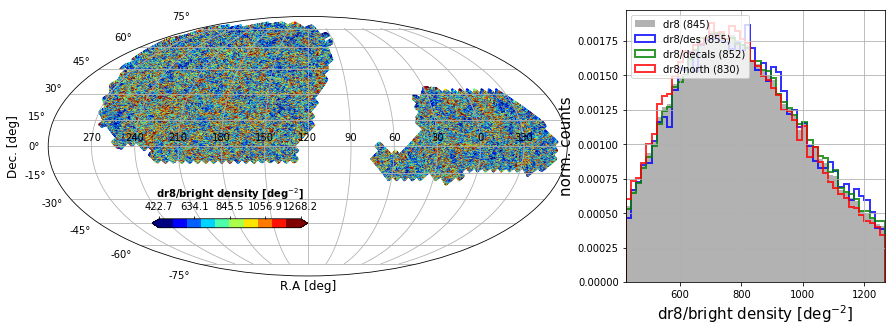

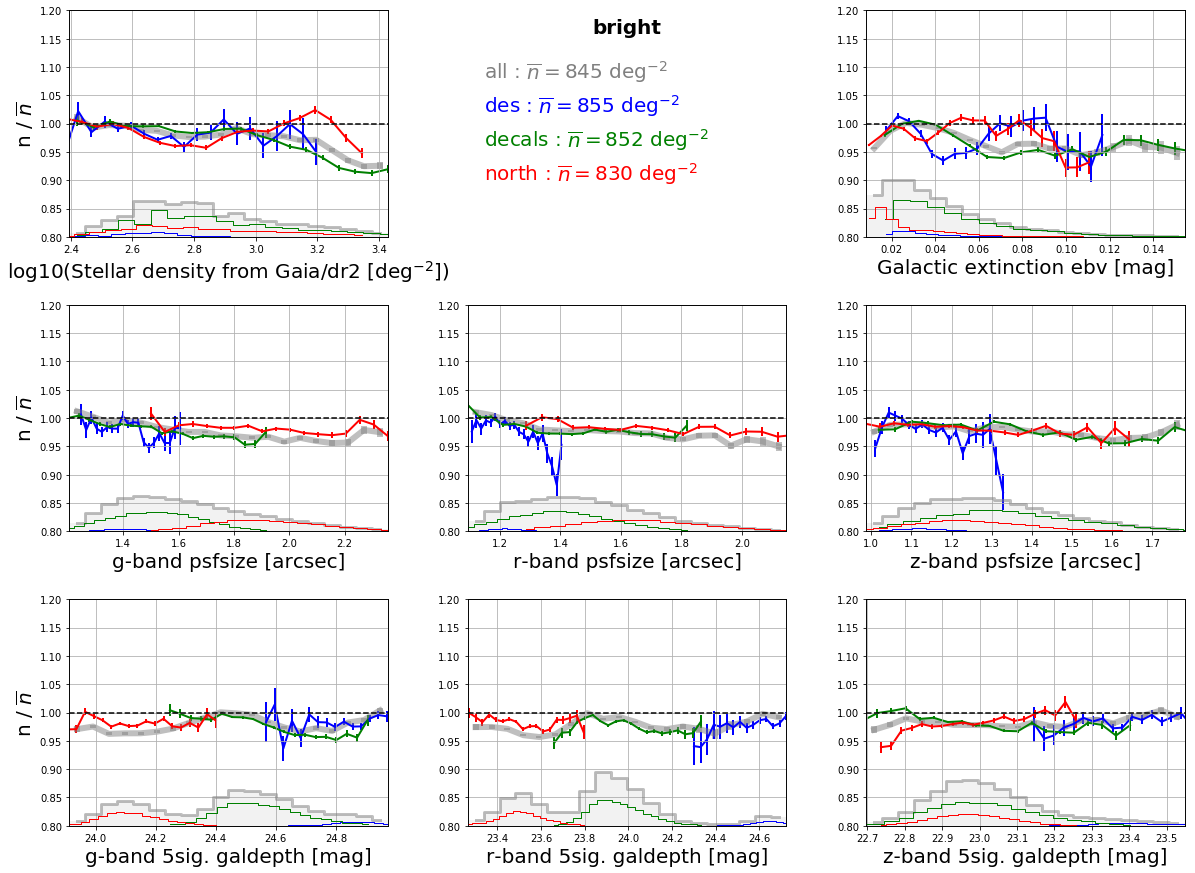



plotting density distributions + systematics for the  faint selection


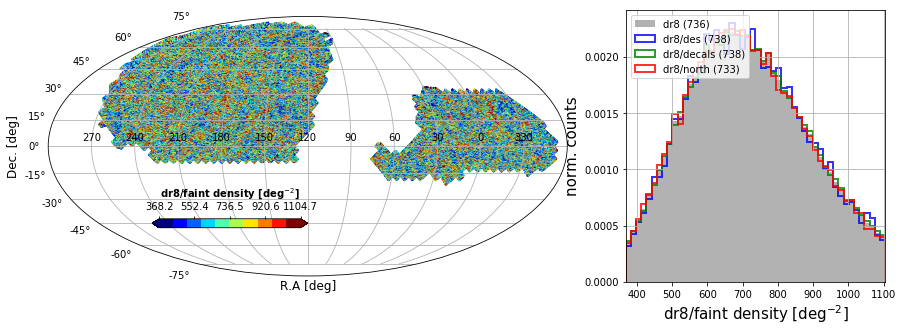

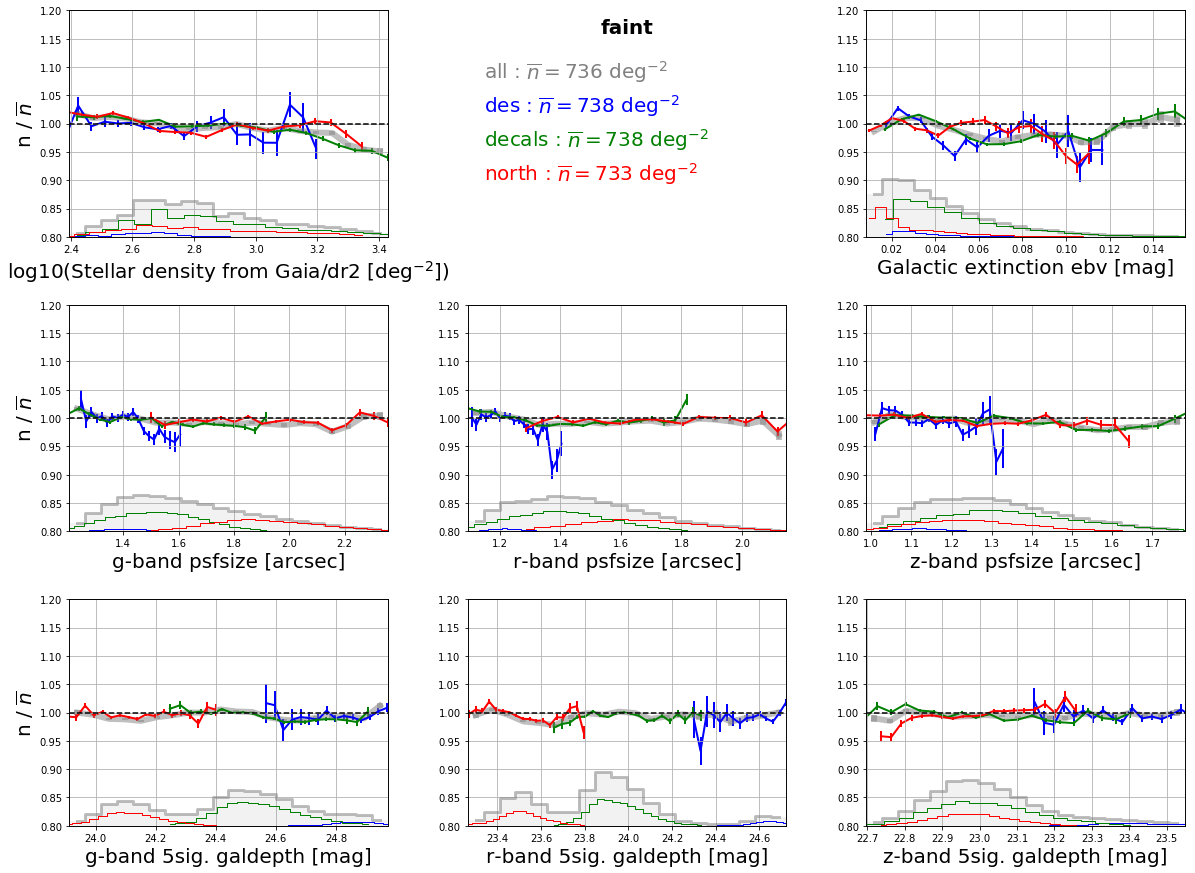



plotting density distributions + systematics for the  faint_ext selection


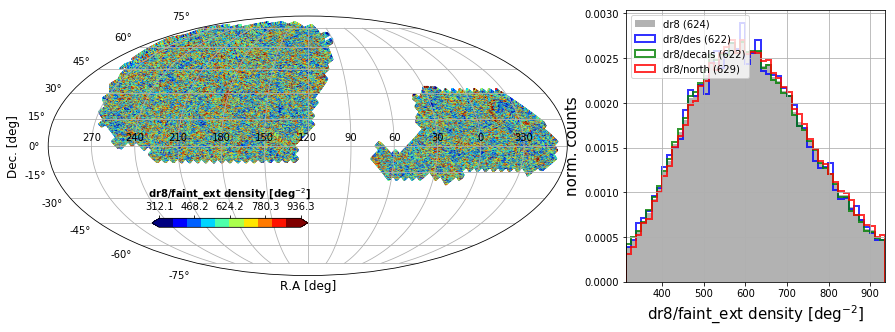

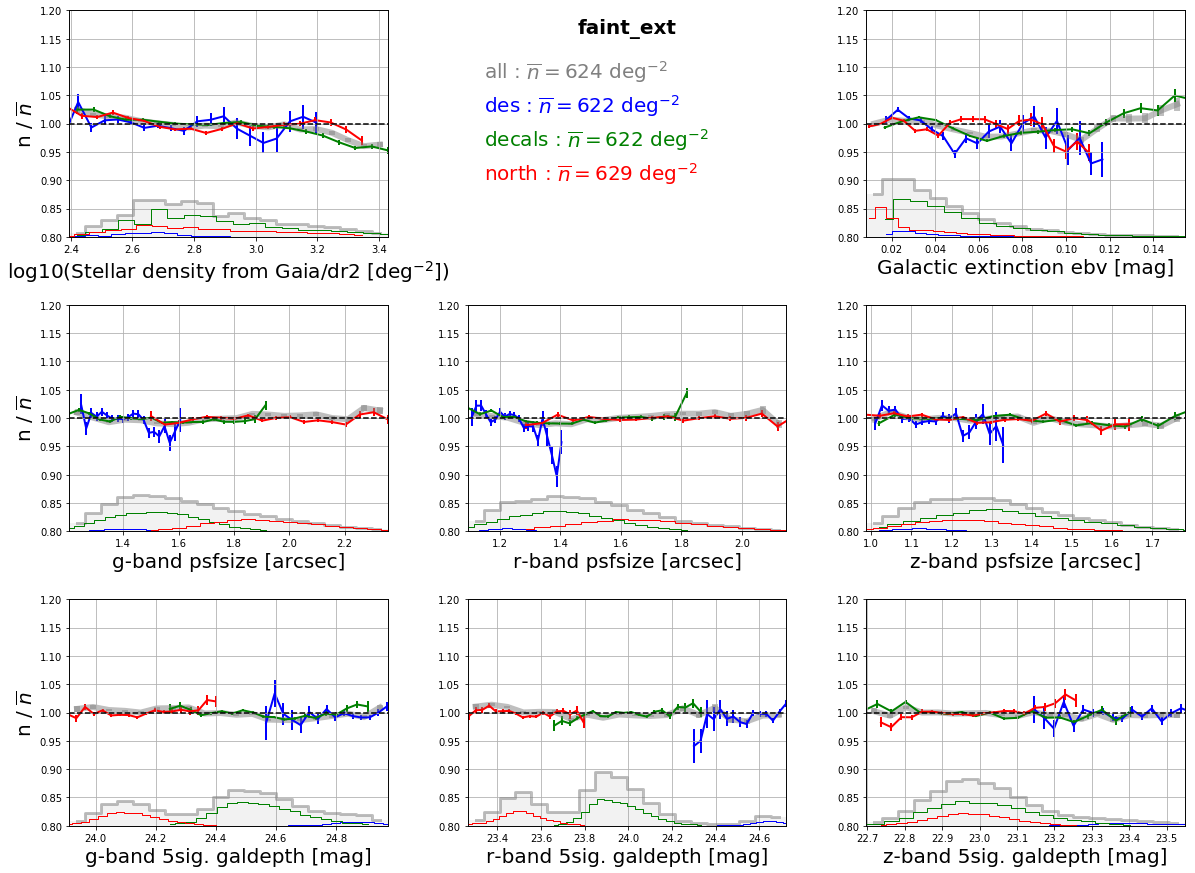



plotting density distributions + systematics for the  fibmag selection


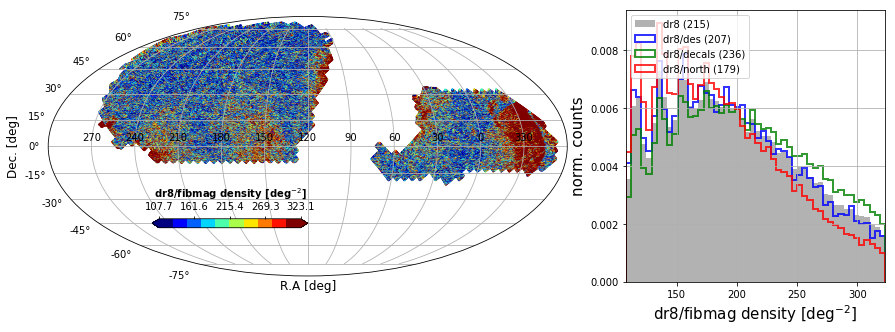

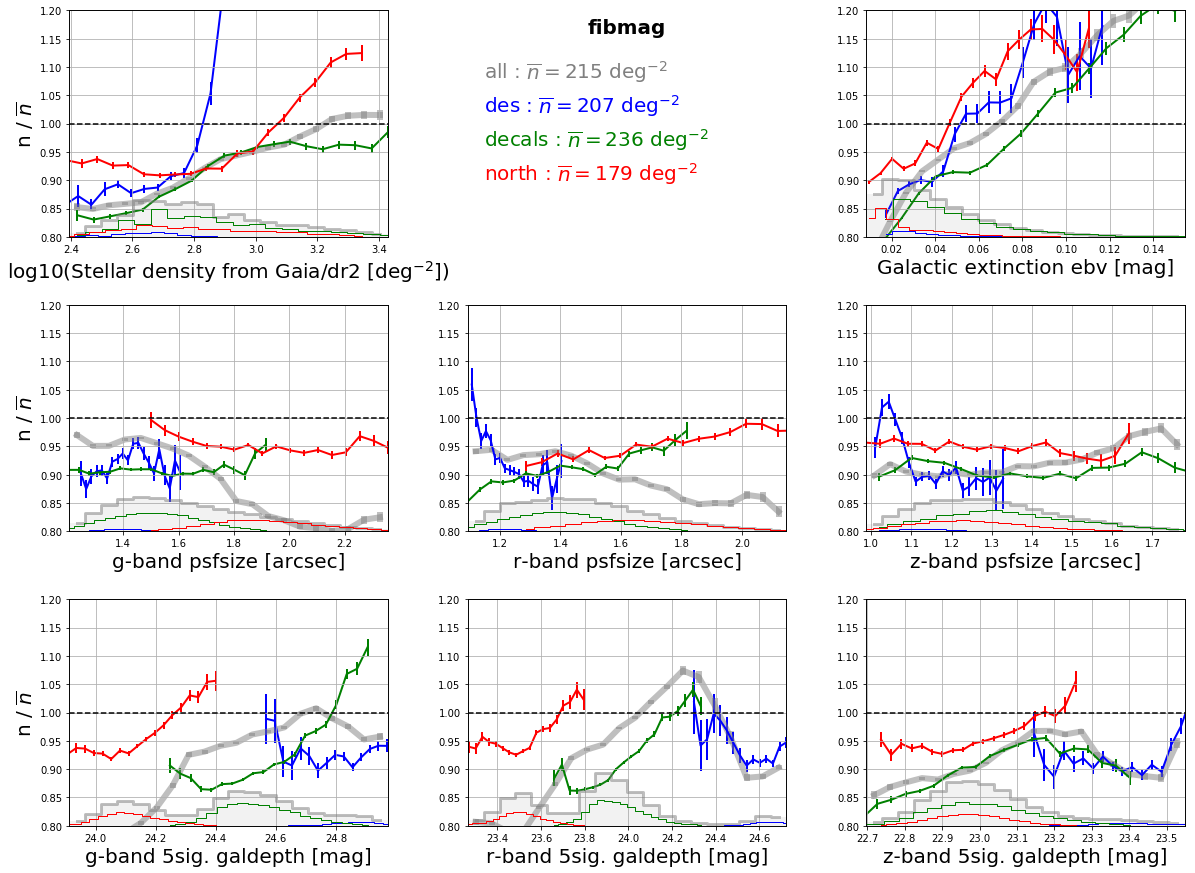



plotting density distributions + systematics for the  lowq selection


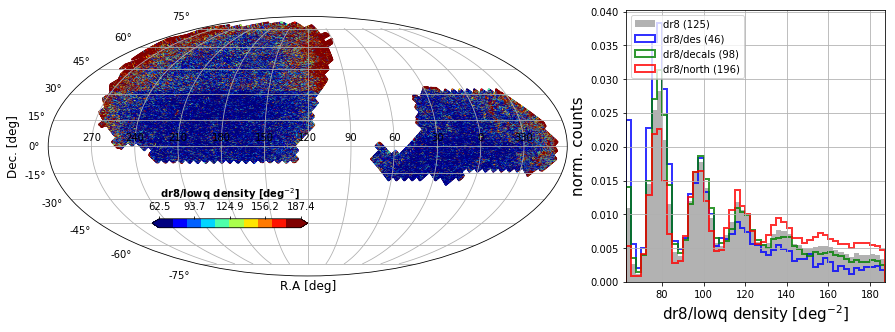

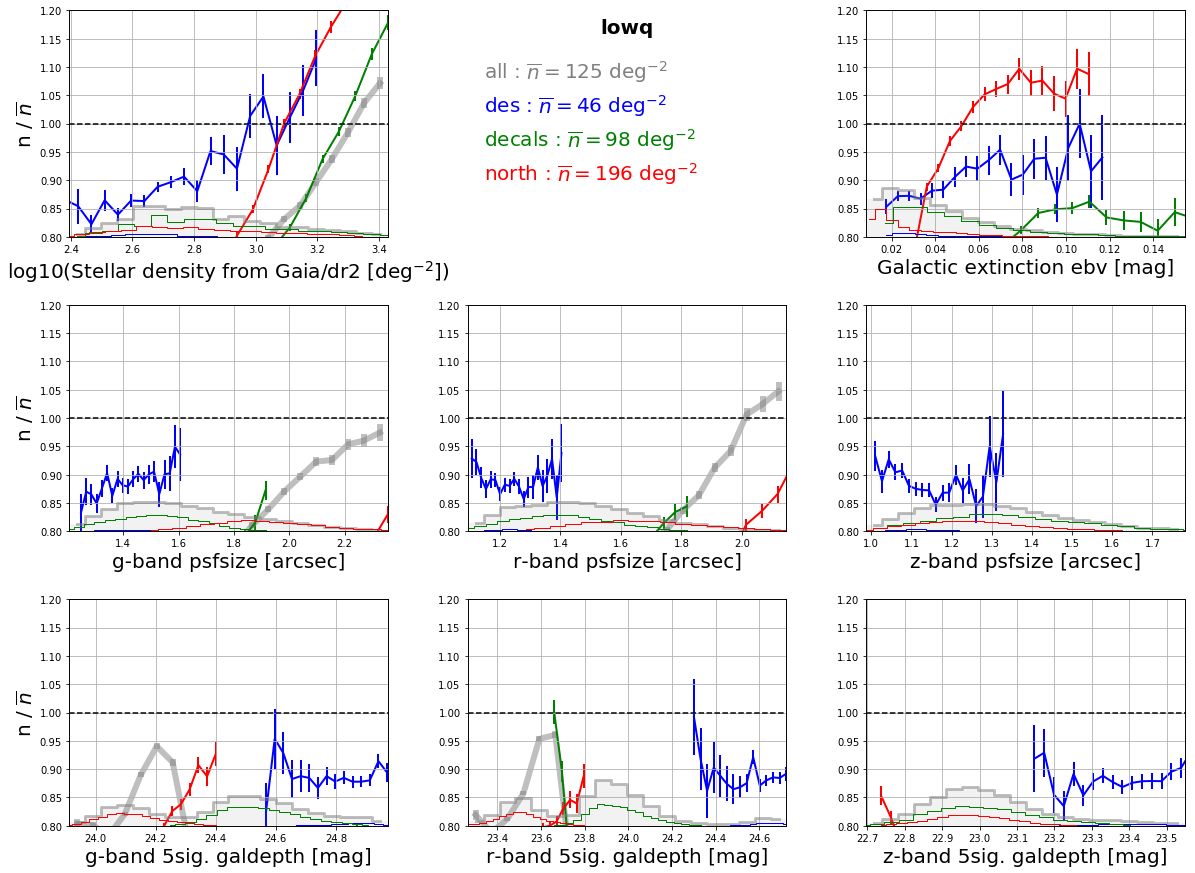



2019-10-15 16:01:23 end


In [138]:
# dr8_south+north : density distributions + systematics
print(raichoorlib.get_date(), 'start')

# subsamples (BGS SV supersets)
namesels = ['bright', 'faint', 'faint_ext', 'fibmag', 'lowq']

# settings
ramw,decmw = get_radec_mw(hpdict['ra'],hpdict['dec'],org)
isdesi     = (hpdict['isdesi']) & (hpdict['bgsfracarea']>0)
systs      = ['stardens','ebv','psfsize_g', 'psfsize_r', 'psfsize_z','galdepth_g', 'galdepth_r', 'galdepth_z']
nx         = 20
densmin,densmax = 0,2
regs       = ['all','des','decals','north']
cols       = ['0.5','b','g','r']

# looping on subselections
for namesel in namesels:
    
    print('plotting density distributions + systematics for the ', namesel, 'selection')
    
    hpdens = (hpdict['south_n'+namesel] + hpdict['north_n'+namesel] ) / (pixarea * hpdict['bgsfracarea'])
    hpmean = hpdict['meandens_'+namesel+'_all']
    cmin,cmax = (0.5*hpmean,1.5*hpmean)
    cbarticks = np.linspace(cmin,cmax,5)
    cbar_ylab = ['%.0f' % x for x in cbarticks]
    clab      = 'dr8/'+namesel+r' density [deg$^{-2}$]'

    # density skymap + hist
    fig        = plt.figure(figsize=(15,5))
    gs         = gridspec.GridSpec(1,2,wspace=0.15,hspace=0.3,width_ratios=[2,1])
    # mollweide
    ax     = plt.subplot(gs[0],projection=projection)
    _      = set_mwd(ax,org=org)
    SC  = ax.scatter(ramw[isdesi],decmw[isdesi],s=1,
        c=hpdens[isdesi],
        cmap=cm,vmin=cmin,vmax=cmax,rasterized=True)
    p  = ax.get_position().get_points().flatten()
    cax= fig.add_axes([p[0]+0.2*(p[2]-p[0]),p[1]+0.2*(p[3]-p[1]),0.3*(p[2]-p[0]),0.025])
    cbar = plt.colorbar(SC, cax=cax, orientation='horizontal', ticklocation='top', extend='both', ticks=cbarticks)
    cbar.set_label(clab,fontweight='bold')
    cbar.ax.set_yticklabels(cbar_ylab)
    # hist
    ax     = plt.subplot(gs[1])
    xgrid  = np.linspace(cmin,cmax,51)
    ax.hist(hpdens[isdesi],
            bins=xgrid,histtype='stepfilled',alpha=0.3,color='k',density=True,
            label='dr8 ('+'%.0f'%hpdict['meandens_'+namesel+'_all']+')')
    for reg,col in zip(regs[1:],cols[1:]):
        tmp    = (isdesi) & (hpdict['is'+reg])
        ax.hist(hpdens[tmp],
                bins=xgrid,histtype='step',alpha=0.8,color=col,lw=2,density=True,
                label='dr8/'+reg+' ('+'%.0f'%hpdict['meandens_'+namesel+'_'+reg]+')')
    ax.set_xlabel(clab,fontsize=15)
    ax.set_ylabel('norm. counts',fontsize=15)
    ax.set_xlim(cmin,cmax)
    #ax.set_ylim(0,5)
    ax.grid(True)
    ax.legend(ncol=1,loc=2)
    plt.show()
    plt.close()
            
    # systematics
    fig    = plt.figure(figsize=(20,15))
    gs     = gridspec.GridSpec(3,3,hspace=0.30,wspace=0.25)
    for i in range(len(systs)):
        syst = systs[i]
        # plot/xlim settings
        xlim, xlabel = get_systplot(syst)
        tmpsyst = hpdict[syst][isdesi]
        xlim = np.percentile(tmpsyst[tmpsyst>0],(1,99))
        xwidth = (xlim[1]-xlim[0])/nx
        # initializing plots
        if (i==0):
            ip = 0
        else:
            ip = 1+i
        if (i==1):
            axinfo = fig.add_subplot(gs[i])
        ax = fig.add_subplot(gs[ip])
        ## systematics
        ax.plot(xlim,[1.,1.],color='k',linestyle='--')
        ax.set_xlim(xlim)
        ax.set_ylim(0.8,1.2)
        ax.set_xlabel(xlabel,fontsize=20)
        if (ip%3==0):
            ax.set_ylabel(r'n / $\overline{n}$',fontsize=20)
        ax.grid(True)
        ## histogram
        axh = ax.twinx()
        axh.set_xlim(xlim)
        axh.set_ylim(0,8)
        axh.axes.get_yaxis().set_ticks([])
        ## systematics
        for reg,col in zip(regs,cols):
            if (reg=='all'):
                isreg    = (isdesi)
                lw,alpha = 3,0.5
            else:
                isreg    = (isdesi) & (hpdict['is'+reg])
                lw,alpha = 1,1.0
            tmpsyst   = hpdict[syst][isreg]
            xlim      = np.percentile(tmpsyst[(tmpsyst>0) & (np.isfinite(tmpsyst))],(1,99))
            tmpdens   = hpdens[isreg]
            tmp       = ((tmpdens/hpdict['meandens_'+namesel+'_'+reg]>densmin) & 
                         (tmpdens/hpdict['meandens_'+namesel+'_'+reg]<densmax) & 
                         (tmpsyst>xlim[0]) & 
                         (tmpsyst<xlim[1]))
            systquant = tmpsyst[tmp]
            systdens  = tmpdens[tmp]
            systdens /= hpdict['meandens_'+namesel+'_'+reg]
            xgrid        = xlim[0]+np.arange(nx+1)/float(nx)*(xlim[1]-xlim[0])
            plotxgrid    = (xgrid[0:-1]+xgrid[1:])/2.
            systnobj     = np.ones(nx)*float('NaN')
            systv        = np.ones(nx)*float('NaN')
            systverr     = np.ones(nx)*float('NaN')
            for j in range(nx):
                tmp      = np.where((systquant >= xgrid[j]) & (systquant < xgrid[j+1]))[0]
                systnobj[j]= len(tmp)
                if (len(tmp) > 0):
                #if ((len(tmp)>0) & (xgrid[j+1]>systmin) & (xgrid[j]<systmax)):
                    #print ' ', xgrid[j] , xgrid[j+1], len(systquant[tmp]), np.mean(systdens[tmp])                
                    systv[j]   = np.mean(systdens[tmp])
                    systverr[j]= np.std (systdens[tmp])/np.sqrt(len(systdens[tmp]))
            tmpl  = 0.05*(xlim[1]-xlim[0])
            tmp = np.isfinite(systv)
            #print syst, t, np.average(systv[tmp],weights=systnobj[tmp]/np.sum(systnobj[tmp]))
            ax.errorbar(plotxgrid,systv,systverr,color=col,ecolor=col,zorder=1,lw=2*lw,alpha=alpha)
            # histogram
            height,_ = np.histogram(systquant,bins=xgrid)
            height   = height.astype(float) / 2.e4
            xcent    = 0.5*(xgrid[1:]+xgrid[:-1])
            if (reg=='all'):
                axh.bar(xcent,height,align='center',width=xwidth,alpha=0.1,color=col)
            axh.step(xcent,height,where='mid',alpha=alpha,lw=lw,color=col)
        # infos
        if (i==1):
            axinfo.axis('off')
            axinfo.text(0.5,0.9,namesel,fontsize=20,fontweight='bold',ha='center',transform=axinfo.transAxes)
            tmpy = 0.7
            for reg,col in zip(regs,cols):
                tmpstr = reg+' : '+r'$\overline{n}=$'+'%.0f'%hpdict['meandens_'+namesel+'_'+reg]+r' deg$^{-2}$'
                axinfo.text(0.05,tmpy,tmpstr,color=col,fontsize=20,transform=axinfo.transAxes)
                tmpy  -= 0.15
    plt.show()
    plt.close()
    print('')
    print('')

print(raichoorlib.get_date(), 'end')